# Youtube Channel correlation anaylsis

# Objective: 
    
To analyze, categorize, and gain insights into YouTube channels to enhance strategic decision-making for marketing, content strategy, and partnerships.

**Business Goals**

***Market Segmentation:*** 

Classify YouTube channels based on content nature and viewer engagement to tailor marketing strategies effectively.

***Content Optimization:***

Identify content themes and trends across different clusters of channels to guide creators on potential areas for content diversification or specialization.

***Partnership Identification:***

Determine suitable channels for brand partnerships, sponsorships, and collaborations based on their content focus and audience reach.

***Performance Benchmarking:*** 

Assess channel performance within their respective categories to set and refine performance benchmarks in content creation and viewer engagement.

In [1]:
import os
import pathlib as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups, get_data_home
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from collections import Counter
import itertools
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.cluster import KMeans
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from scipy.sparse import hstack
import re
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

seed=42

Load input data and print the initial number of entries.
Replace "NA" in the 'Channel_contents' column with np.nan and then drop these NaN values.
Print the number of entries after cleaning 'Channel_contents'.
Replace "NA" in 'Primary_Language' and drop these NaN values, followed by printing the count.
Confirm that there are no entries with "NA" or NaN in both 'Channel_contents' and 'Primary_Language'.
Print the final number of entries after all cleaning steps.

In [2]:
# Setting seed for reproducibility
np.random.seed(seed)

# Load the data
data = pd.read_csv('Global_YouTube_Statistics_import.csv', 
                   delimiter='\t', 
                   encoding='latin1')

# Initial data count
print("Initial total entries:", len(data))

# Replace 'NA' with np.nan (if not already NaN) in 'Channel_contents'
data['Channel_contents'].replace('NA', np.nan, inplace=True)

# Drop rows where 'Channel_contents' is NaN and explicitly copy the DataFrame
data_cleaned = data.dropna(subset=['Channel_contents']).copy()

# Count after cleaning 'Channel_contents'
print("Entries after cleaning 'Channel_contents':", len(data_cleaned))

# Now clean 'Primary_Language'
data_cleaned['Primary_Language'].replace('NA', np.nan, inplace=True)
data_cleaned = data_cleaned.dropna(subset=['Primary_Language'])

# Count after cleaning 'Primary_Language'
print("Entries after cleaning 'Primary_Language':", len(data_cleaned))
# Final entries count
print("Total entries after cleaning:", len(data_cleaned))


Initial total entries: 950
Entries after cleaning 'Channel_contents': 879
Entries after cleaning 'Primary_Language': 853
Total entries after cleaning: 853


We check **NA** and **NaN** in the  Channel_contents

In [3]:
# Verify cleaning process
string_na_cleaned = data_cleaned[data_cleaned['Channel_contents'] == 'NA']
missing_na_cleaned = data_cleaned[data_cleaned['Channel_contents'].isna()]


print(f"Rows with 'Channel_contents' as string 'NA' after cleaning: {len(string_na_cleaned)}")
print(f"Rows with 'Channel_contents' missing (NaN) after cleaning: {len(missing_na_cleaned)}")

# Verify cleaning process
string_na_cleaned = data_cleaned[data_cleaned['Primary_Language'] == 'NA']
missing_na_cleaned = data_cleaned[data_cleaned['Primary_Language'].isna()]


print(f"Rows with 'Primary_Language' as string 'NA' after cleaning: {len(string_na_cleaned)}")
print(f"Rows with 'Primary_Language' missing (NaN) after cleaning: {len(missing_na_cleaned)}")


Rows with 'Channel_contents' as string 'NA' after cleaning: 0
Rows with 'Channel_contents' missing (NaN) after cleaning: 0
Rows with 'Primary_Language' as string 'NA' after cleaning: 0
Rows with 'Primary_Language' missing (NaN) after cleaning: 0


In [4]:
data_cleaned.head

<bound method NDFrame.head of      rank                    Youtuber  \
0       1                    T-Series   
1       2                     MrBeast   
2       3  Cocomelon - Nursery Rhymes   
3       4                   SET India   
4       5             Kids Diana Show   
..    ...                         ...   
945   946             GustavoParodias   
946   947              SAAIHALILINTAR   
947   948                    Timba Vk   
948   949    Heidi and Zidane HZHtube   
949   950                    DaniRep    

                                      Channel_contents Primary_Language  \
0    A premier music label, T-Series has become a c...            Hindi   
1    Led by philanthropist and entertainer Jimmy Do...          English   
2    Specializes in 3D animated videos of classic n...          English   
3    A variety channel featuring a mix of reality T...            Hindi   
4    Chronicles the playful adventures of Diana and...          English   
..                         

Synonym Replacement in Text Data: Normalizes text to consolidate similar terms for more precise analysis.

In [5]:
# Synonym mapping dictionary
synonyms = {
    'Indian': 'India',
    'Hindi': 'India',
    'vlogs': 'vlog',
    'kids': 'children',  
    'kid': 'children',
    'songs':'children',
    'video':'videos',
    'videoss':'videos'
}

# Function to replace synonyms in the text
def replace_synonyms(text):
    for key, value in synonyms.items():
        text = text.replace(key, value)
    return text

# Apply the function to the 'Channel_contents' column
data_cleaned['Channel_contents'] = data_cleaned['Channel_contents'].apply(replace_synonyms)

# K-means clustering for Channel Contents

In this part we will be clustering the channel contents.  
This task will consist of lo vectorizing the text input and then fitting k-means model to the data to gain insights.

In [6]:
# Extract the 'Channel_contents' column for vectorization
Channel_contents = data_cleaned['Channel_contents']

In [7]:
# Tokenize the content into words
words = list(itertools.chain(*[content.lower().split() for content in Channel_contents]))

# Create a counter of words
word_counter = Counter(words)

# Define the list of specific words you want to check the frequency for
specific_words = [
    "subscribe", "follow", "social",
    "instagram", "facebook", "twitter", "new",
    "official", "watch", "like", "comment",
    "share", "link", "description", "click", "update", "videos", "video", "channel", "channels", "featuring", "known", "providing", "focused", "offering"
]

# Get the frequency of each specific word
specific_word_counts = {word: word_counter[word] for word in specific_words}

print(specific_word_counts)

{'subscribe': 0, 'follow': 0, 'social': 11, 'instagram': 0, 'facebook': 0, 'twitter': 0, 'new': 5, 'official': 127, 'watch': 1, 'like': 4, 'comment': 0, 'share': 2, 'link': 1, 'description': 0, 'click': 0, 'update': 0, 'videos': 114, 'video': 1, 'channel': 446, 'channels': 1, 'featuring': 195, 'known': 150, 'providing': 40, 'focused': 13, 'offering': 47}


In [8]:
# Update the stop words list with both singular and plural forms of certain words
stop_words = list(ENGLISH_STOP_WORDS.union(['video', 'videos', 'channel', 'channels', 'content', 'contents', "featuring","known","providing", "focused", 'and', 'for', 's', 'offers', 
                     'range', 'focus', 'offering', 'features', 'popular','indonesian']))


# Create a TfidfVectorizer with the updated list of stop words
vectorizer = TfidfVectorizer(stop_words=stop_words)


# Convert your 'texts' into vectors
X = vectorizer.fit_transform(Channel_contents)

Hierarchical clustering

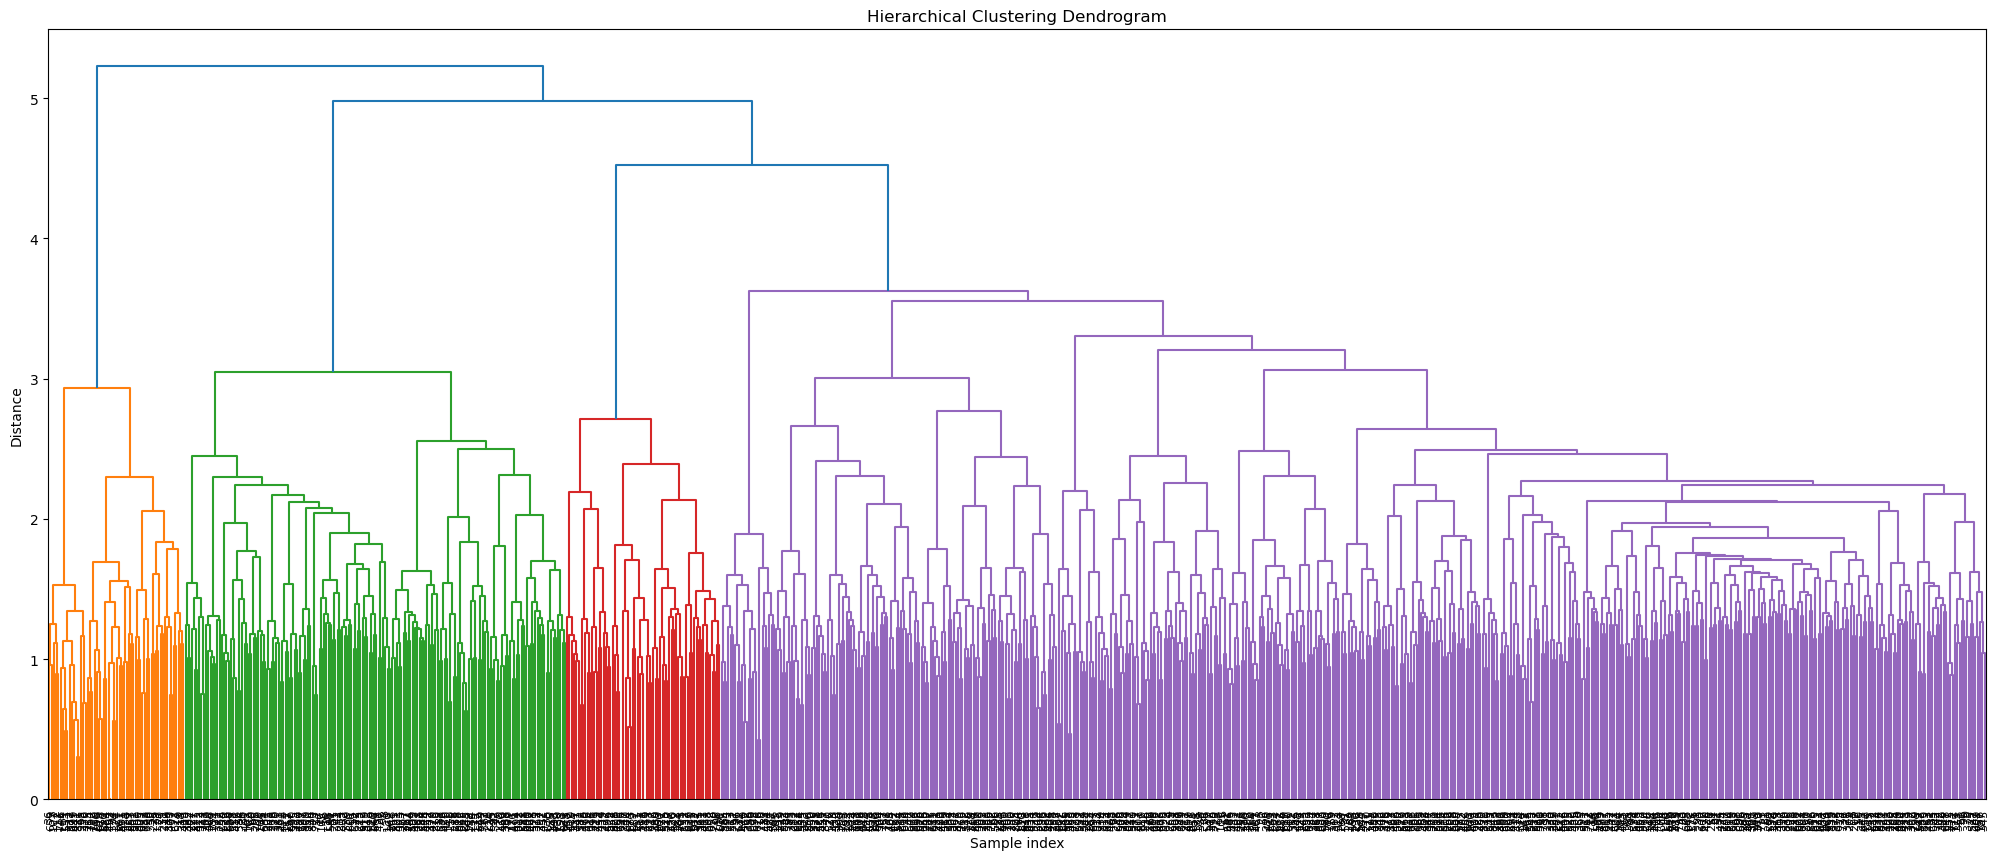

In [9]:
# Generate the linkage matrix using Ward's method
Z = linkage(X.toarray(), 'ward')

# Set the figure size to be large enough to see details
plt.figure(figsize=(25, 10))

# Plot the dendrogram
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

In [10]:
# Determine clusters at the specified distance
max_d = 3.7  # decided
clusters = fcluster(Z, max_d, criterion='distance')

# Number of clusters formed
number_of_clusters = len(set(clusters))
print(f'Number of clusters formed: {number_of_clusters}')

Number of clusters formed: 4


In [11]:
# Assuming you have defined 'seed' and 'X' previously and 'data_cleaned' is your original DataFrame
kmeans_model = KMeans(n_clusters=number_of_clusters, n_init=10, random_state=seed)

# Fit the model on the X data
kmeans_model.fit(X)

# The model is now fitted to the data, and we can get the cluster assignments for each data point
cluster_assignments = kmeans_model.labels_

# Add the cluster assignments back to the original dataframe safely using .loc
data_cleaned.loc[:, 'Cluster'] = cluster_assignments

# Now we can examine the first few entries to see the cluster assignments
print(data_cleaned.head())

   rank                    Youtuber  \
0     1                    T-Series   
1     2                     MrBeast   
2     3  Cocomelon - Nursery Rhymes   
3     4                   SET India   
4     5             Kids Diana Show   

                                    Channel_contents Primary_Language  \
0  A premier music label, T-Series has become a c...            Hindi   
1  Led by philanthropist and entertainer Jimmy Do...          English   
2  Specializes in 3D animated videos of classic n...          English   
3  A variety channel featuring a mix of reality T...            Hindi   
4  Chronicles the playful adventures of Diana and...          English   

   subscribers  video views        category                       Title  \
0    245000000     2,28E+11           Music                    T-Series   
1    166000000  28368841870   Entertainment                     MrBeast   
2    162000000     1,64E+11       Education  Cocomelon - Nursery Rhymes   
3    159000000     1,48E+1

We will now make a **wordcloud** of the most common words in each cluster. 

In [12]:

# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

Creation of **wordclouds for each cluster**

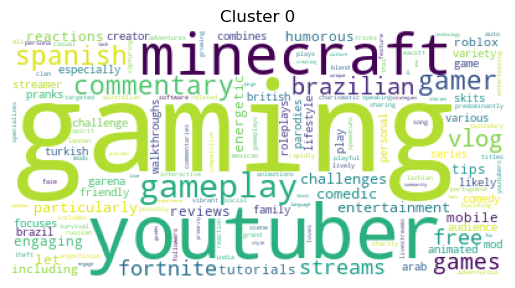

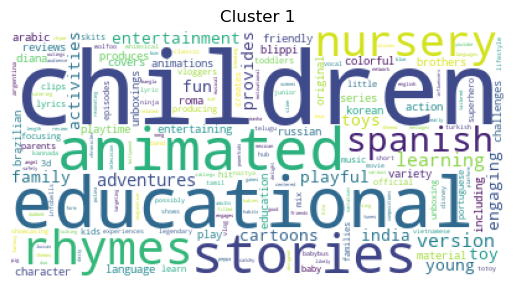

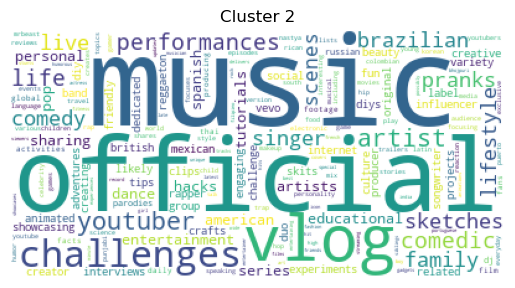

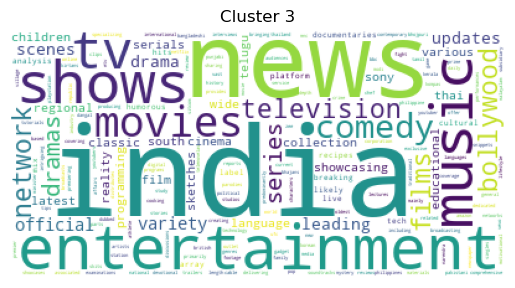

In [13]:
# Get the order of centroids
order_centroids = kmeans_model.cluster_centers_.argsort()[:, ::-1]
# Get the feature names from the vectorizer
terms = vectorizer.get_feature_names_out()  # or vectorizer.get_feature_names() for older versions

# Create a DataFrame with the cluster centers and the feature names as columns
centroids = pd.DataFrame(kmeans_model.cluster_centers_)
centroids.columns = terms

# Now you can use your function to generate word clouds
generateWordClouds(centroids)

# Clustering considering also the channels primary_languages

In [14]:
# Check and output counts of 'NA' and NaN values in 'Channel_contents'
string_na = data_cleaned[data_cleaned['Primary_Language'] == 'NA']
missing_na = data_cleaned[data_cleaned['Primary_Language'].isna()]

print(f"Rows with 'Channel_contents' as string 'NA': {len(string_na)}")
print(f"Rows with 'Channel_contents' missing (NaN): {len(missing_na)}")
print (len(data_cleaned))

Rows with 'Channel_contents' as string 'NA': 0
Rows with 'Channel_contents' missing (NaN): 0
853


In [15]:
# Clean "NA" values in 'Primary_Language'
data_cleaned = data_cleaned[~data_cleaned['Primary_Language'].astype(str).str.match(r"^NA$", case=False)]
data_cleaned = data_cleaned.dropna(subset=['Primary_Language'])

print (len(data_cleaned))

853


In [16]:
# Check and output counts of 'NA' and NaN values in 'Channel_contents'
string_na = data_cleaned[data_cleaned['Primary_Language'] == 'NA']
missing_na = data_cleaned[data_cleaned['Primary_Language'].isna()]

print(f"Rows with 'Channel_contents' as string 'NA': {len(string_na)}")
print(f"Rows with 'Channel_contents' missing (NaN): {len(missing_na)}")

Rows with 'Channel_contents' as string 'NA': 0
Rows with 'Channel_contents' missing (NaN): 0


One-hot encode the 'Primary_Language' data as this is a categorical variable. This creates a binary column for each language, which indicates the presence or absence of each language with a 1 or 0. This is the right approach because it ensures that the categorical nature of the language data is preserved and each language is given equal weight, whereas vectorizing it like Channel_contents would not be appropriate.

If we were to simply vectorize the Primary_Language like you do with Channel_contents, the model might incorrectly interpret the language data as a sort of "text" data, which would not accurately represent the distinct, separate categories that languages are.

In [17]:
# Create a TfidfVectorizer with the updated list of stop words
vectorizer = TfidfVectorizer(stop_words=stop_words)

# Convert 'Channel_contents' into vectors
X_contents = vectorizer.fit_transform(Channel_contents)  # Pass series directly
text_features = vectorizer.get_feature_names_out()


# One-hot encode the 'Primary_Language' data
onehot_encoder = OneHotEncoder()
X_lang = onehot_encoder.fit_transform(data_cleaned[['Primary_Language']].astype(str)) # Ensure data is string type
language_features = onehot_encoder.get_feature_names_out()

# Combine the text and language features
X_combined = hstack([X_contents, X_lang])



print(X_contents.shape)
print(X_lang.shape)
print(X_combined.shape)
print(data_cleaned.shape)


(853, 1442)
(853, 32)
(853, 1474)
(853, 31)


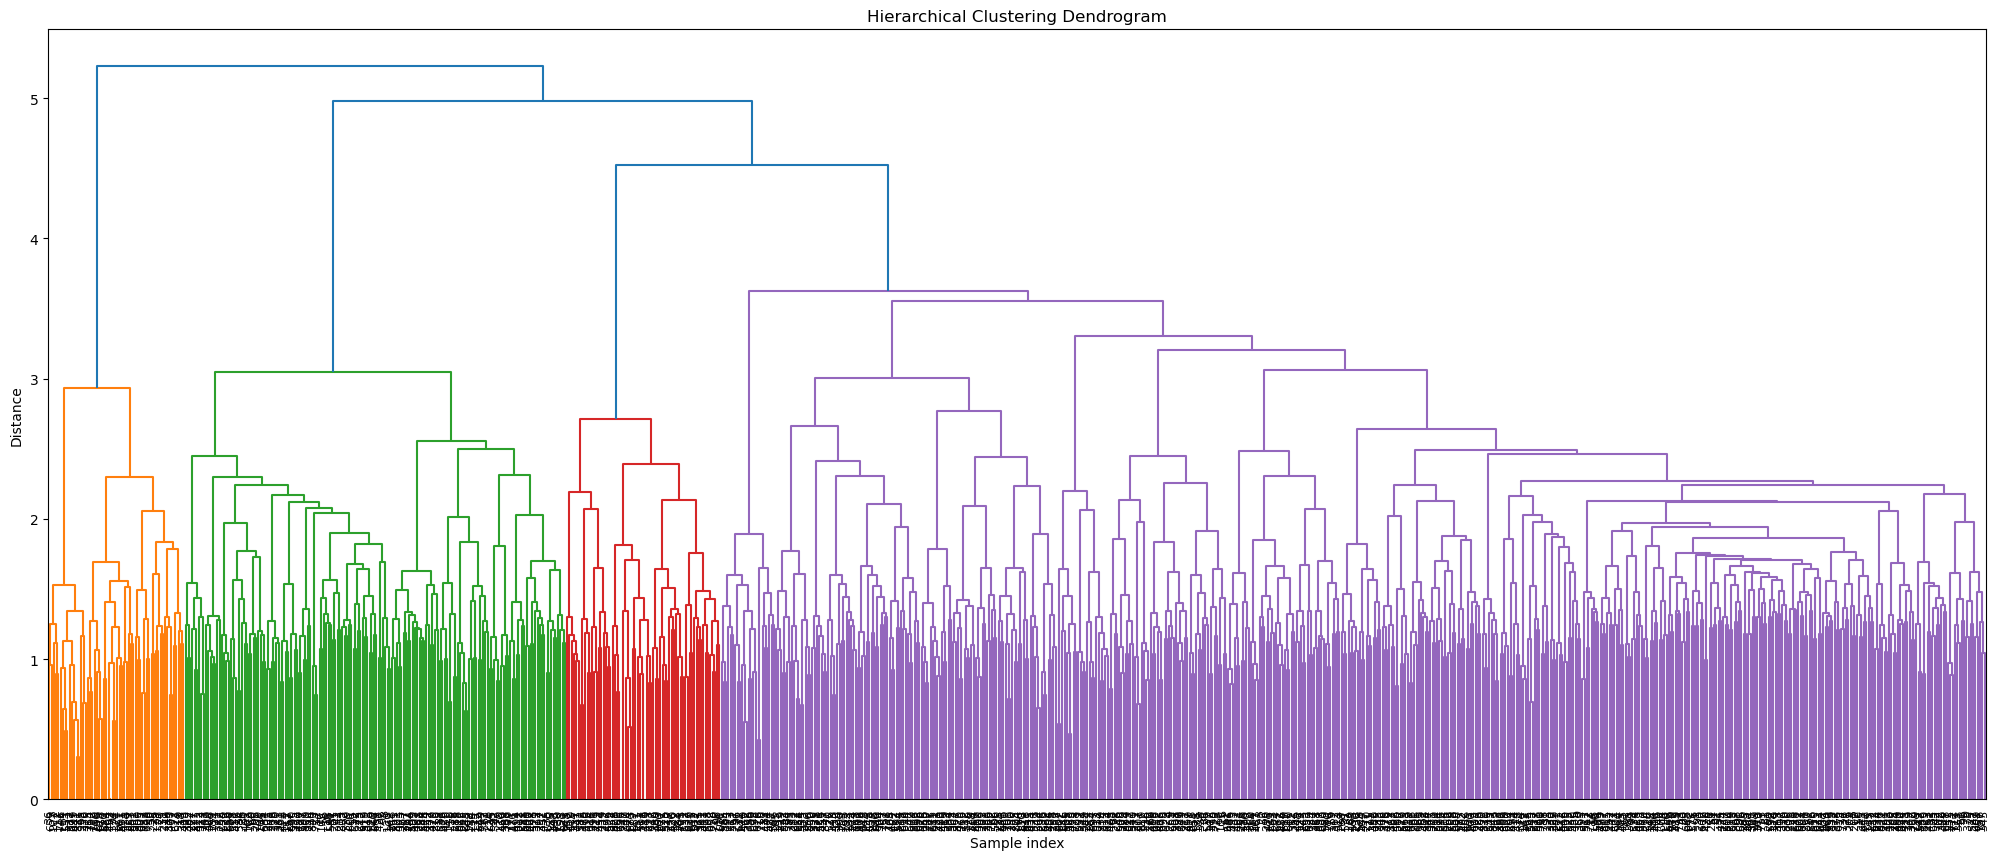

In [18]:
# Generate the linkage matrix using Ward's method
Z = linkage(X.toarray(), 'ward')

# Set the figure size to be large enough to see details
plt.figure(figsize=(25, 10))

# Plot the dendrogram
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

In [19]:
# Determine clusters at the specified distance
max_d = 3.7  # decided
clusters = fcluster(Z, max_d, criterion='distance')

# Number of clusters formed
number_of_clusters = len(set(clusters))
print(f'Number of clusters formed: {number_of_clusters}')

Number of clusters formed: 4


In [20]:
# Create and fit the new KMeans model
kmeans_model2 = KMeans(n_clusters=number_of_clusters, n_init=10, random_state=seed)
kmeans_model2.fit(X_combined)

# Get the cluster assignments from the new model
data_cleaned['Cluster2'] = kmeans_model2.labels_

# Check the first few entries to see the cluster assignments
print(data_cleaned.head())
print(data_cleaned.shape)

   rank                    Youtuber  \
0     1                    T-Series   
1     2                     MrBeast   
2     3  Cocomelon - Nursery Rhymes   
3     4                   SET India   
4     5             Kids Diana Show   

                                    Channel_contents Primary_Language  \
0  A premier music label, T-Series has become a c...            Hindi   
1  Led by philanthropist and entertainer Jimmy Do...          English   
2  Specializes in 3D animated videos of classic n...          English   
3  A variety channel featuring a mix of reality T...            Hindi   
4  Chronicles the playful adventures of Diana and...          English   

   subscribers  video views        category                       Title  \
0    245000000     2,28E+11           Music                    T-Series   
1    166000000  28368841870   Entertainment                     MrBeast   
2    162000000     1,64E+11       Education  Cocomelon - Nursery Rhymes   
3    159000000     1,48E+1

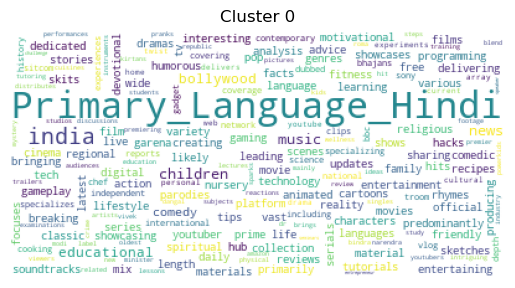

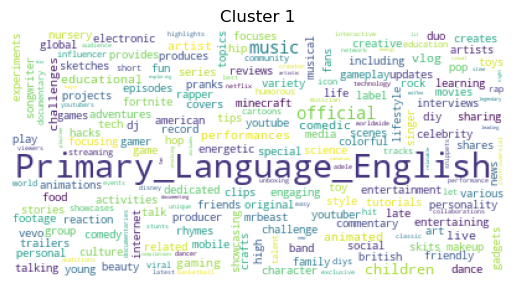

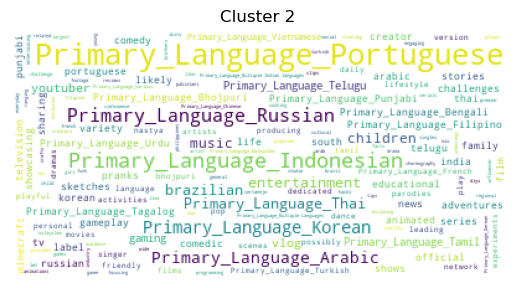

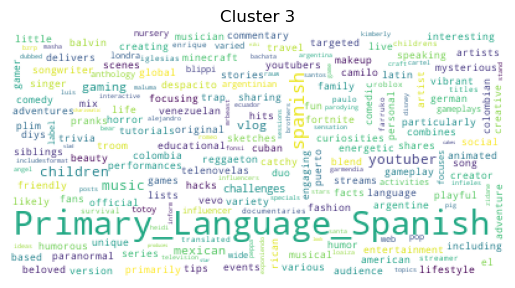

In [21]:
# Get the order of centroids to identify top contributing features for each cluster
order_centroids = kmeans_model2.cluster_centers_.argsort()[:, ::-1]

# Combine the feature names from both text and language
combined_features = np.concatenate([text_features, language_features])

# Create the centroids DataFrame using the combined features
centroids = pd.DataFrame(kmeans_model2.cluster_centers_, columns=combined_features)


# Generate word clouds or other analyses
generateWordClouds(centroids)


# Analysis correlation words

In [22]:
# Combine custom stop words with the default English stop words
stop_words = ENGLISH_STOP_WORDS.union(stop_words)

# Tokenize the content into words, ensuring they are in lowercase and punctuation is managed
words = list(itertools.chain(*[re.findall(r'\b\w+\b', re.sub(r"'\w\b", '', content.lower())) for content in data_cleaned['Channel_contents']]))

# Filter out the stop words
filtered_words = [word for word in words if word not in stop_words]

# Create a counter of the filtered words and get the most common 30
filtered_word_counter = Counter(filtered_words)
most_common_filtered_words = filtered_word_counter.most_common(30)

# Create a DataFrame
word_freq_df = pd.DataFrame(most_common_filtered_words, columns=['Word', 'Frequency'])

# Add a 'Rank' column that represents the ranking of words based on their frequency
word_freq_df.insert(0, 'Rank', range(1, len(word_freq_df) + 1))

# Print the DataFrame to verify the column names and data
print(word_freq_df.head())

# Check column names
print("DataFrame columns:", word_freq_df.columns)

   Rank      Word  Frequency
0     1     music        245
1     2  children        161
2     3  official        127
3     4     india        117
4     5      vlog         95
DataFrame columns: Index(['Rank', 'Word', 'Frequency'], dtype='object')


In [23]:
# Print the first few rows of the DataFrame to understand its structure
print(word_freq_df.head(30))

# Print the DataFrame columns to confirm the presence of the 'Word' column
print(word_freq_df.columns)

    Rank           Word  Frequency
0      1          music        245
1      2       children        161
2      3       official        127
3      4          india        117
4      5           vlog         95
5      6         gaming         85
6      7       youtuber         80
7      8  entertainment         73
8      9    educational         72
9     10     challenges         69
10    11           news         56
11    12       animated         52
12    13         family         49
13    14        spanish         48
14    15         series         45
15    16        comedic         44
16    17      brazilian         44
17    18   performances         42
18    19           life         42
19    20         comedy         41
20    21           live         40
21    22        stories         38
22    23         artist         37
23    24       sketches         34
24    25         scenes         33
25    26         singer         33
26    27        variety         32
27    28          sh

In [24]:
# Count the frequency of each 'Primary_Language'
language_counts = data_cleaned['Primary_Language'].value_counts().reset_index()

# Rename the columns for clarity
language_counts.columns = ['Primary_Language', 'Frequency']

# Reset index to get the rank starting from 1
language_counts.index = language_counts.index + 1
language_counts.reset_index(inplace=True)
language_counts.rename(columns={'index': 'Rank'}, inplace=True)

print(language_counts)

    Rank           Primary_Language  Frequency
0      1                    English        367
1      2                      Hindi        127
2      3                    Spanish        117
3      4                 Portuguese         63
4      5                 Indonesian         28
5      6                    Russian         23
6      7                     Korean         21
7      8                     Arabic         18
8      9                       Thai         15
9     10                     Telugu          8
10    11                      Tamil          8
11    12                    Punjabi          7
12    13                       Urdu          6
13    14                    Bengali          5
14    15                    Tagalog          5
15    16                   Bhojpuri          5
16    17                   Filipino          4
17    18                 Vietnamese          3
18    19                     French          3
19    20                    Turkish          3
20    21     

In [25]:
# Check for 'NA' strings in 'video views'
na_string_counts = data_cleaned['video views'].astype(str).str.contains('NA').sum()

# Check for NaN values in 'video views'
nan_value_counts = data_cleaned['video views'].isna().sum()

print(f"'NA' string count in 'video views': {na_string_counts}")
print(f"NaN value count in 'video views': {nan_value_counts}")

'NA' string count in 'video views': 0
NaN value count in 'video views': 0


# Correlation between words

We analyze the correlation between the occurrences of the top 12 words in video content and to visualize how these words co-occur across different videos, which may help in understanding content themes or the focus of the channel.

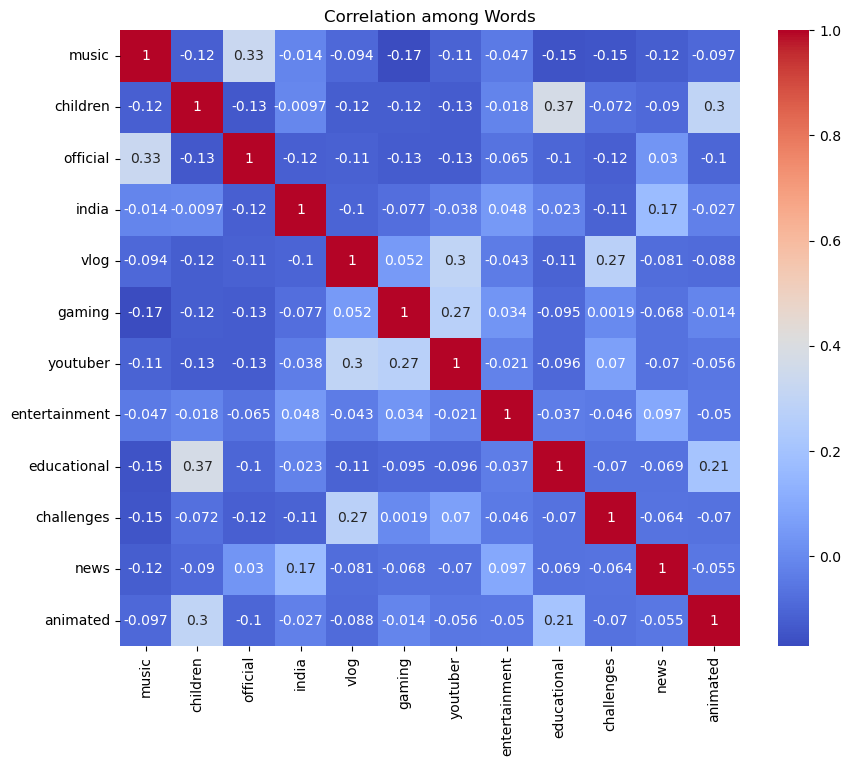

In [26]:
# Assuming 'data_cleaned' and 'word_freq_df' are properly prepared

# Define the words of interest
words_of_interest = word_freq_df['Word'].head(12).tolist()

# Initialize CountVectorizer
vectorizer = CountVectorizer(vocabulary=words_of_interest, binary=True)

# Vectorize the 'Channel_contents'
word_matrix = vectorizer.fit_transform(data_cleaned['Channel_contents']).toarray()

# Create DataFrame for word frequencies
word_freq_matrix_df = pd.DataFrame(word_matrix, columns=vectorizer.get_feature_names_out())

# Join this DataFrame with the subscribers and video views
analysis_df = data_cleaned.join(word_freq_matrix_df)

# Clean and convert 'video views' column
analysis_df['video views'] = analysis_df['video views'].replace(',', '', regex=True).astype(float).astype(int)

# Convert 'subscribers' column to int
analysis_df['subscribers'] = analysis_df['subscribers'].astype(int)

# Correlation among the 12 most frequent words
correlation_words = analysis_df[vectorizer.get_feature_names_out()].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_words, annot=True, cmap='coolwarm')
plt.title('Correlation among Words')
plt.show()

#  Analysis videos views and subscribers with words frequency

Normalization of subscriber video view 

We analyze the impact of specific word occurrences within video content on viewer engagement metrics, by correlating the presence of the top 12 words from a frequency data set with subscriber counts and video views. 
We then visualizes these correlations using a heatmap, providing insights into which words might be driving or correlating with higher engagement metrics.

In [27]:
# Load your cleaned data
# data_cleaned = pd.read_csv('path_to_your_cleaned_data.csv')

# Assuming data_cleaned is already loaded and prepared
# Replace commas and convert video views from string to integers
data_cleaned['video views'] = data_cleaned['video views'].replace(',', '', regex=True).astype(float).astype(int)
data_cleaned['subscribers'] = data_cleaned['subscribers'].astype(int)

# Initialize the scaler
scaler = MinMaxScaler()

# Normalize the 'subscribers' and 'video views'
data_cleaned['norm_subscribers'] = scaler.fit_transform(data_cleaned[['subscribers']])
data_cleaned['norm_video_views'] = scaler.fit_transform(data_cleaned[['video views']])

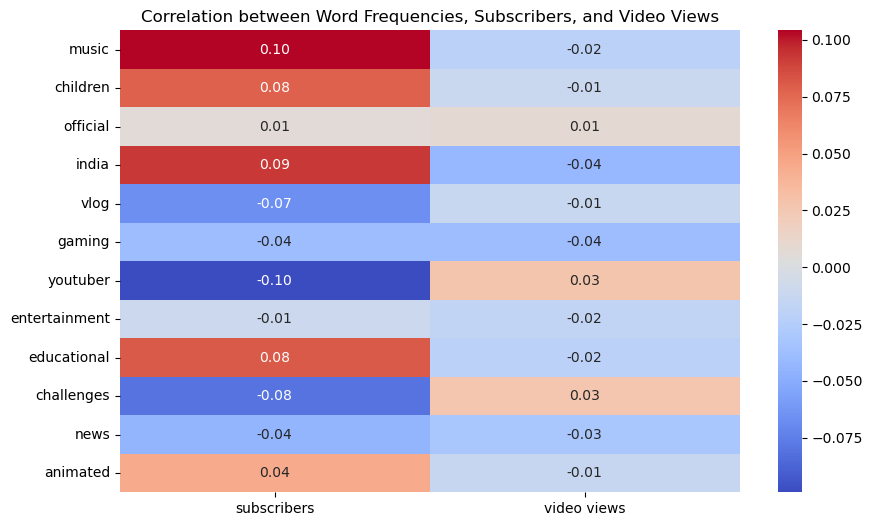

In [28]:
# Load your cleaned data
# Assuming 'data_cleaned' and 'word_freq_df' are properly prepared

# Define the words of interest
words_of_interest = word_freq_df['Word'].head(12).tolist()

# Initialize CountVectorizer
vectorizer = CountVectorizer(vocabulary=words_of_interest, binary=True)

# Vectorize the 'Channel_contents'
word_matrix = vectorizer.fit_transform(data_cleaned['Channel_contents']).toarray()

# Create DataFrame for word frequencies
word_freq_matrix_df = pd.DataFrame(word_matrix, columns=vectorizer.get_feature_names_out())

# Join this DataFrame with the subscribers and video views
analysis_df = data_cleaned.join(word_freq_matrix_df)
analysis_df['video views'] = analysis_df['video views'].replace(',', '', regex=True).astype(float).astype(int)
analysis_df['subscribers'] = analysis_df['subscribers'].astype(int)

# Calculate correlation matrix for subscribers and video views
correlation_matrix = analysis_df[vectorizer.get_feature_names_out().tolist() + ['subscribers', 'video views']].corr()
correlation_subset = correlation_matrix.loc[vectorizer.get_feature_names_out(), ['subscribers', 'video views']]

# Plot the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_subset, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between Word Frequencies, Subscribers, and Video Views')
plt.show()


# Latent Dirichlet Allocation (LDA)

We will check a more sofisticated approach for associating topic using Latent Dirichlet Allocation (LDA)

The use of bi-grams and tri-grams (groupings of two and three words) in the TF-IDF vectorizer allows the model to capture phrases, which can be more expressive than single words. This can lead to more meaningful topics, as phrases often hold more specific meaning than individual words.

Top words per topic:
Topic #1:
entertainment india news music gaming youtuber challenges children educational vlog


Topic #2:
children educational animated news india music official challenges entertainment gaming


Topic #3:
vlog gaming youtuber challenges india music entertainment animated children official


Topic #4:
official music news vlog india children entertainment educational challenges gaming


Topic #5:
music india challenges children vlog youtuber entertainment animated official educational




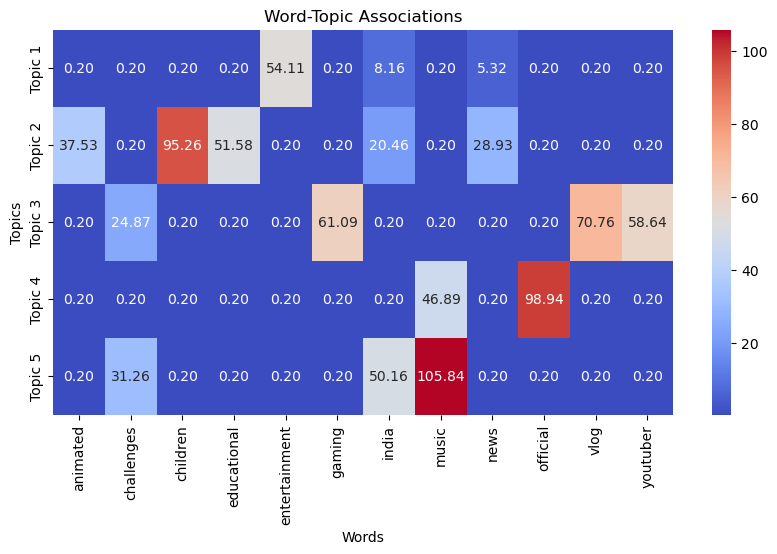

In [29]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming data_cleaned is your DataFrame and 'Channel_contents' has been loaded properly
# Define your custom stop words
stop_words = list(ENGLISH_STOP_WORDS.union(['video', 'videos', 'channel', 'channels', 'content', 'contents', "featuring","known","providing", "focused", 'and', 'for', 's', 'offers', 
                     'range', 'focus', 'offering', 'features', 'popular','indonesian']))

# Initialize TfidfVectorizer with bi-grams and tri-grams
vectorizer = TfidfVectorizer(ngram_range=(1, 3), stop_words=stop_words, max_features=12)

# Fit and transform 'Channel_contents'
X_tfidf = vectorizer.fit_transform(data_cleaned['Channel_contents'])

# Apply LDA for topic modeling
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, random_state=seed)
topics = lda.fit_transform(X_tfidf)

# Display the top words in each topic
feature_names = vectorizer.get_feature_names_out()
print("Top words per topic:")
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic #{topic_idx + 1}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]))
    print("\n")

# Optional: Display a heatmap of the word-topic associations
plt.figure(figsize=(10, 5))
sns.heatmap(lda.components_, annot=True, fmt=".2f", cmap="coolwarm",
            xticklabels=vectorizer.get_feature_names_out(),
            yticklabels=[f'Topic {i+1}' for i in range(lda.n_components)])
plt.title('Word-Topic Associations')
plt.xlabel('Words')
plt.ylabel('Topics')
plt.show()

# Distinct Topics identified:

**Topic 1**  heavily associate with words like "vlog," "youtuber," and "gaming," which could suggest channels focused on personal vlogging and gaming content.

**Topic 2** emphasizes "entertainment," "gaming," and "news," hinting at channels that may cover current events in entertainment and gaming.

**Topic 3** highlights "music," "india," and "children," which could point to channels with content related to music for children or music from India.

**Topic 4** has a strong association with "official," which might indicate official channels of creators, artists, or brands.

**Topic 5** includes "children," "educational," and "animated," suggesting channels that produce educational content for children, possibly through animation.

**Broad Terms:**
Words like "entertainment," "music," and "official" are quite broad and appear across multiple topics. This could indicate either a wide variety of channel content related to these terms or perhaps that the distinction between topics is not very sharp. A more nuanced set of terms or a different number of topics might yield a clearer distinction.

**Potential Overlap:**
The presence of similar words across topics, such as "entertainment," "challenges," and "music," implies that there is some overlap in the type of content these topics represent. This could be due to the multifaceted nature of the channels or perhaps a need to refine the topic modeling process.

# Utilizing RandomForestClassifier to predict channel categories based on historical data.

The goal of this part is to classifie YouTube channels into categories like 'Popular', 'Influential', and 'Elite' based on various features including video views, uploads, and content descriptions. This classification aids in strategic business decisions, enabling targeted marketing and content strategy development tailored to channel reach and potential. By employing a RandomForestClassifier, the model provides robust, mixed-data handling and generates important performance metrics like accuracy and Features importance. In practice, integrating this model within business operations facilitates data-driven decision-making enhancing operational efficiency.


In [30]:
# Drop rows with NaN values in 'country_rank' and 'channel_type_rank' columns
data_cleaned = data_cleaned.dropna(subset=['country_rank', 'channel_type_rank','Population','Urban_population',])

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from scipy.sparse import hstack

# Load and prepare your data
# data_cleaned = pd.read_csv('path_to_your_data.csv')

# Drop rows with NaN in 'country_rank' and 'channel_type_rank'
data_cleaned.dropna(subset=['channel_type_rank'], inplace=True)  # Removed 'country_rank'

# Categorize the 'subscribers' into three levels: 'Popular', 'Influential', 'Elite'
bins = [0, 19999999, 29999999, np.inf]
labels = ['Popular', 'Influential', 'Elite']
data_cleaned['subscriber_category'] = pd.cut(data_cleaned['subscribers'], bins=bins, labels=labels)

# Custom stop words and other preprocessing
custom_stop_words = ['video', 'videos', 'channel', 'channels', 'content', 'contents', "featuring", "known", "providing", "focused", 'and', 'for', 's', 'offers', 'range', 'focus', 'offering', 'features', 'popular', 'indonesian']
stop_words_combined = ENGLISH_STOP_WORDS.union(set(custom_stop_words))
vectorizer = TfidfVectorizer(stop_words=list(stop_words_combined), max_features=8)

# Fit and transform the 'Channel_contents'
X_tfidf = vectorizer.fit_transform(data_cleaned['Channel_contents'])

# Initialize scaler and one-hot encoder
scaler = MinMaxScaler()
onehot_encoder = OneHotEncoder()

# Normalize numerical features
norm_video_views = scaler.fit_transform(data_cleaned[['video views']].astype(float))
norm_uploads = scaler.fit_transform(data_cleaned[['uploads']])

# Normalize the ranking features
# norm_country_rank = scaler.fit_transform(data_cleaned[['country_rank']].astype(float))  # Removed 'country_rank'
norm_video_views_rank = scaler.fit_transform(data_cleaned[['video_views_rank']].astype(float))
norm_channel_type_rank = scaler.fit_transform(data_cleaned[['channel_type_rank']].astype(float))

# One-Hot Encoding for categorical features
onehot_primary_language = onehot_encoder.fit_transform(data_cleaned[['Primary_Language']])

# Combining all features into one feature set, without 'country_rank'
X_combined = hstack([
    X_tfidf,
    norm_video_views,
    norm_uploads,
    onehot_primary_language,
    norm_video_views_rank,
    norm_channel_type_rank
])

# Target variable
y = data_cleaned['subscriber_category'].values

# Split the data into training/validation and independent test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=seed)

# Parameters for GridSearchCV
param_grid = {
    'n_estimators': [20, 50, 100, 150, 1000],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20, 30],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize and fit the GridSearchCV
rf = RandomForestClassifier(random_state=seed)
grid_search = GridSearchCV(rf, param_grid, cv=10, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train_val, y_train_val)  # Using all remaining data for training and validation

# Print the best parameters and best cross-validation score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", round(grid_search.best_score_, 4))

# Evaluate the model on the independent test set
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print('Random Forest final independent test score:', round(test_score, 4))


Fitting 10 folds for each of 300 candidates, totalling 3000 fits
Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score: 0.8101
Random Forest final independent test score: 0.7949


In [32]:
y = data_cleaned['subscriber_category'].values
# Print unique classes and their counts
class_counts = data_cleaned['subscriber_category'].value_counts()
print(class_counts)

# Print unique classes
unique_classes = data_cleaned['subscriber_category'].unique()
print("Unique classes in 'subscriber_category':", unique_classes)

subscriber_category
Popular        452
Influential    173
Elite          152
Name: count, dtype: int64
Unique classes in 'subscriber_category': ['Elite', 'Influential', 'Popular']
Categories (3, object): ['Popular' < 'Influential' < 'Elite']


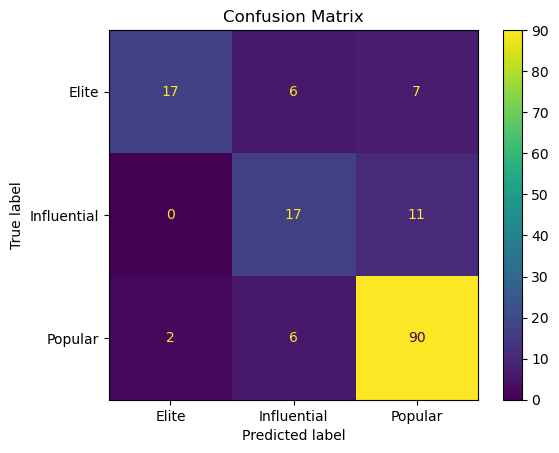

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
conf_mat = confusion_matrix(y_test, best_model.predict(X_test))

# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=best_model.classes_)

# Use the display object to plot the confusion matrix
disp.plot()
plt.title('Confusion Matrix')
plt.show()


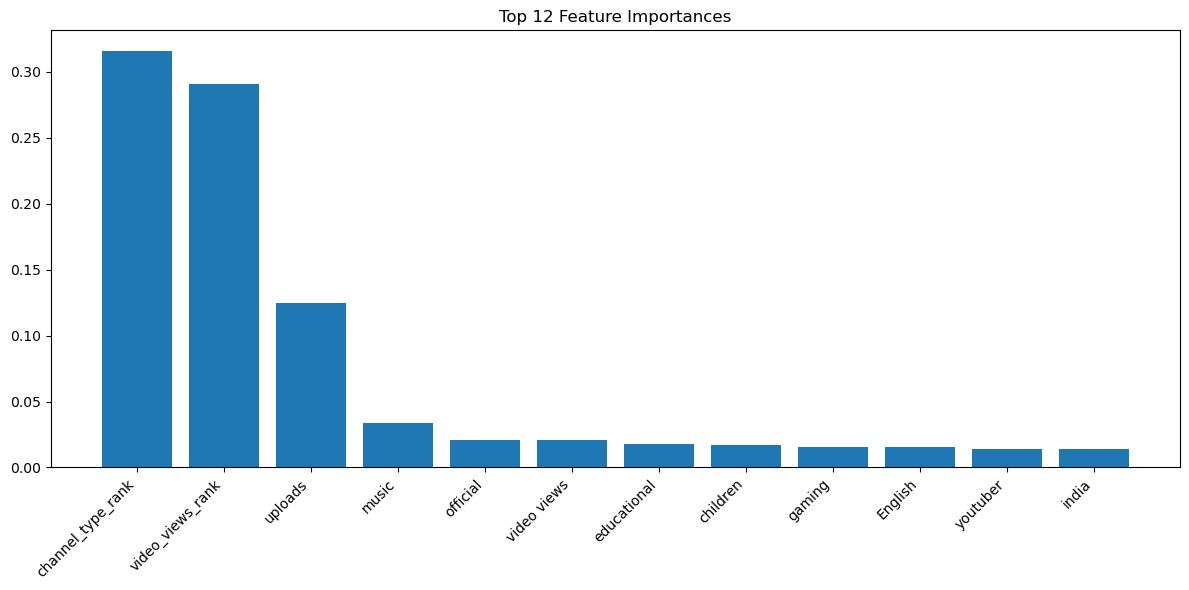

In [34]:
# Get the list of categories for each categorical feature
categories = onehot_encoder.categories_

# Combine the feature names from TF-IDF and one-hot encoded features
feature_names = vectorizer.get_feature_names_out().tolist() + \
                ['video views', 'uploads'] + \
                list(np.concatenate(categories)) + \
                ['video_views_rank', 'channel_type_rank']

# Get the feature importances from the best model
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Limit to the top 12 features
top_indices = indices[:12]

# Plot the top 12 feature importances
plt.figure(figsize=(12, 6))
plt.title('Top 12 Feature Importances')
plt.bar(range(len(top_indices)), importances[top_indices], align='center')
plt.xticks(range(len(top_indices)), [feature_names[i] for i in top_indices], rotation=45, ha="right")
plt.tight_layout()
plt.show()


# RandomForestClassifier model results
**The RandomForestClassifier model achieved a cross-validation score of 81.01% and an independent test score of 79.49%, indicating a reliable performance in categorizing YouTube channels into 'Popular', 'Influential', and 'Elite' categories based on their content and viewership metrics. The project results show a good level of accuracy in classifying YouTube channel categories. However, the confusion matrix indicates that the classification of 'Elite' channels is less precise compared to 'Popular' and 'Influential' ones. Therefore, with additional data or by obtaining a more balanced and comprehensive dataset, there is potential to further refine the model, enhance its predictive capabilities, and reduce misclassification rates.**